# Approximation du problème SAT par des réseaux de neurones

## Déduction naturelle et arbre de preuve

Soit $\Gamma$ un ensemble de formules et $\phi$ une formule à prouver. Un arbre de preuve en déduction naturelle pour $\Gamma \vdash \phi$ est construit selon les règles d'inférence standard, e.g. :

$$
\frac{A \quad A \rightarrow B}{B} \quad (\text{Modus Ponens})
$$

## Vérification et problème SAT

La vérification d'une preuve se réduit à vérifier la validité de chaque étape, ce qui peut être formulé comme un problème SAT :

$$
\text{SAT}(\phi) = \exists x_1, \ldots, x_n \in \{0,1\} : \phi(x_1, \ldots, x_n) = 1
$$


où $\phi$ est une formule booléenne sur $n$ variables.

### Schéma d'introduction

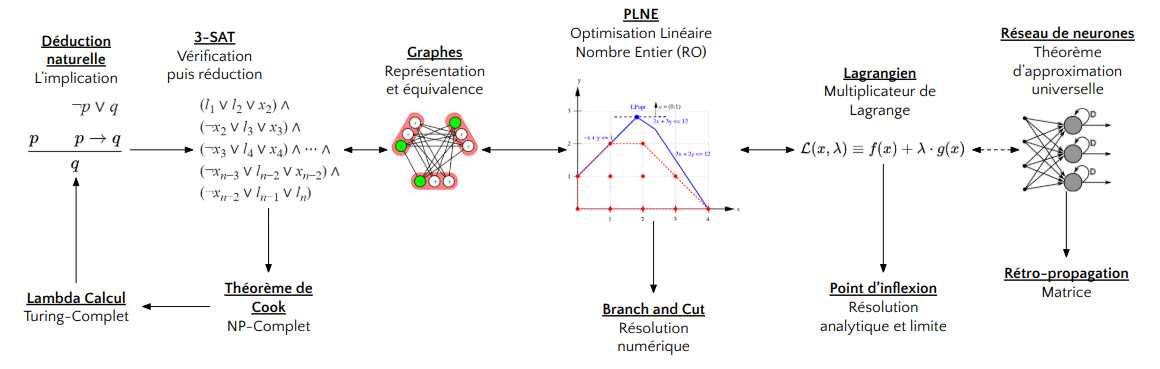

In [ ]:
import tensorflow as tf
import numpy as np
import itertools



## Réduction à 3-SAT

Toute formule SAT peut être transformée en 3-SAT en temps polynomial. Pour une clause $C = (l_1 \vee l_2 \vee \ldots \vee l_k)$ avec $k > 3$, on introduit des variables auxiliaires :

$$
(l_1 \vee l_2 \vee y_1) \wedge (\neg y_1 \vee l_3 \vee y_2) \wedge \ldots \wedge (\neg y_{k-3} \vee l_{k-1} \vee l_k)
$$


### Théorème de Cook via le lambda-calcul

Le théorème de Cook peut être démontré en utilisant le lambda-calcul plutôt que les machines de Turing :

1. **Encodage des configurations** : Chaque configuration d'une machine non-déterministe est représentée par un terme du lambda-calcul.
2. **Transitions** : Les règles de transition sont exprimées par des formules booléennes en lambda-calcul.
3. **Formule globale** : On construit une formule $\phi$ exprimant l'existence d'une séquence valide de configurations menant à un état acceptant.
4. **Réduction** : On montre que toute instance d'un problème NP peut être traduite en une formule SAT équivalente en utilisant cet encodage.

Cette approche démontre la NP-complétude de SAT en utilisant le formalisme du lambda-calcul.

### Représentation en graphes

Pour 3-SAT, on peut construire un graphe $G = (V, E)$ où :
- $V = \{x_1, \ldots, x_n, \neg x_1, \ldots, \neg x_n\}$
- $E = \{(l_i, l_j) : \exists \text{ clause } (l_i \vee l_j \vee l_k)\}$

Cette représentation est un exemple parmi d'autres schémas d'équivalence avec SAT, illustrant la versatilité du problème.

### Génération de problème SAT


In [ ]:
def generate_sat_problem(num_variables, num_clauses):
    """
    Generates a random SAT problem ensuring that each variable appears only once per clause
    and that the variables are in ascending order.
    """
    clauses = []

    for _ in range(num_clauses):
        # Générer 3 variables uniques aléatoires
        variables = tf.random.shuffle(tf.range(1, num_variables + 1))[:3]

        # Trier les variables pour qu'elles soient en ordre croissant
        variables = tf.sort(variables)

        # Générer des signes aléatoires pour les variables
        signs = tf.random.uniform((3,), minval=0, maxval=2, dtype=tf.int32) * 2 - 1

        # Créer la clause en combinant les variables avec leurs signes
        clause = variables * signs
        clauses.append(clause)

    return tf.stack(clauses)

In [ ]:
num_variables = 5
num_clauses = 10
original_clauses = generate_sat_problem(num_variables, num_clauses)
original_clauses

<tf.Tensor: shape=(10, 3), dtype=int32, numpy=
array([[ 1,  3,  4],
       [-2,  3,  4],
       [-1, -4,  5],
       [-1, -2,  5],
       [-2, -4, -5],
       [-1, -2,  5],
       [ 1, -2,  5],
       [-3,  4, -5],
       [ 2, -3, -4],
       [ 1,  3,  4]], dtype=int32)>

## Formulation en OLNE

Le problème 3-SAT peut être formulé comme un problème d'optimisation :

--> pas ok ! un probleme de "faisabilité" avec $c^T \cdot x=0$ et $A \cdot x > 1$ (si cas exigent "toutes les clauses doivent etre rempli" : $A \cdot x = 3 $, bof.. encore mieux si l'inegalité est prise en compte !), Lagrangien a adapté qqsoit le systeme d'optimisation linéaire.

$$
\begin{aligned}
\min_{x \in \{0,1\}^n} & \sum_{c \in \text{clauses}} (1 - \sum_{l \in c} l) \\
\text{s.t. } & x_i + \neg x_i > 0, \quad \forall i = 1,\ldots,n
\end{aligned}
$$


In [ ]:
def sat_to_plne_params(clauses):
    num_clauses = tf.shape(clauses)[0]
    num_variables = tf.reduce_max(tf.abs(clauses))  # Nombre maximum de variables

    S = tf.zeros((num_clauses + 1, num_variables + 1), dtype=tf.float32)

    indices = tf.abs(clauses) - 1  # Indices pour les colonnes (0-indexed)
    updates = tf.cast(tf.sign(clauses), tf.float32)  # +1 ou -1 selon le signe du littéral
    batch_indices = tf.repeat(tf.range(num_clauses), 3)  # Indices des clauses

    scatter_indices = tf.stack([batch_indices, tf.reshape(indices, [-1])], axis=1)

    S = tf.tensor_scatter_nd_add(S, scatter_indices, tf.reshape(updates, [-1]))

    S = S.numpy()
    S[-1, :-1] = 1.0  # b
    S[:-1, -1] = .0  # c
    return tf.constant(S)

In [ ]:
optim = sat_to_plne_params(original_clauses)
A = optim[:-1, :-1]
print(A)

tf.Tensor(
[[ 1.  0.  1.  1.  0.]
 [ 0. -1.  1.  1.  0.]
 [-1.  0.  0. -1.  1.]
 [-1. -1.  0.  0.  1.]
 [ 0. -1.  0. -1. -1.]
 [-1. -1.  0.  0.  1.]
 [ 1. -1.  0.  0.  1.]
 [ 0.  0. -1.  1. -1.]
 [ 0.  1. -1. -1.  0.]
 [ 1.  0.  1.  1.  0.]], shape=(10, 5), dtype=float32)


### Passage d'OLNE vers SAT (vérification)

Pour transformer un problème d'optimisation linéaire et non linéaire (OLNE) en SAT :

1. **Discrétisation** : Les variables continues sont discrétisées avec une précision fixée.
2. **Encodage binaire** : Chaque variable discrète est encodée en binaire.
3. **Contraintes** : Les contraintes linéaires et non linéaires sont transformées en formules booléennes équivalentes.
4. **Fonction objectif** : La fonction objectif est encodée comme une série de comparaisons binaires.

Cette transformation permet de résoudre un problème OLNE en utilisant un solveur SAT.

In [ ]:
def plne_params_to_sat(A):
    num_clauses = tf.shape(A)[0]
    clauses = []

    for i in range(num_clauses):
        clause = []
        for j in range(tf.shape(A)[1]):
            if A[i, j] != 0:  # Vérifier si le littéral est présent
                literal = j + 1 if A[i, j] > 0 else -(j + 1)
                clause.append(literal)
        clauses.append(clause)

    return tf.constant(clauses)

In [ ]:
reconstructed_clauses = plne_params_to_sat(A)
if np.array_equal(original_clauses, reconstructed_clauses):
    print("Les clauses sont identiques.")
else:
    print("Les clauses ne sont pas identiques.")
reconstructed_clauses

Les clauses sont identiques.


<tf.Tensor: shape=(10, 3), dtype=int32, numpy=
array([[ 1,  3,  4],
       [-2,  3,  4],
       [-1, -4,  5],
       [-1, -2,  5],
       [-2, -4, -5],
       [-1, -2,  5],
       [ 1, -2,  5],
       [-3,  4, -5],
       [ 2, -3, -4],
       [ 1,  3,  4]], dtype=int32)>

## Relaxation lagrangienne

On relaxe les contraintes $x_i + \neg x_i = 1$ en les intégrant dans la fonction objectif :

$$
L(x, \lambda) = \sum_{c \in \text{clauses}} (1 - \sum_{l \in c} l) + \lambda \cdot \sum_{i=1}^n A_i \cdot x - b_i
$$

--> pas ok ! un probleme de "faisabilité" avec $c^T \cdot x=0$ et $A \cdot x > 1$, Lagrangien a adapté qqsoit le systeme d'optimisation linéaire, ici uniquement sur les contraintes finalement (le lagrangien doit etre egale à 0 --> mettre au carré et inclure l'inegalité !) .


In [ ]:
import tensorflow as tf
import numpy as np

class LagrangianLoss(tf.keras.losses.Loss):
    def __init__(self, lambda_init=1.0, name="lagrangian_loss"):
        super().__init__(name=name)  # start with light violation cost
        self.lambda_ = tf.Variable(lambda_init, trainable=True)

    def call(self, S, x):
        # S : [A, b, c] PLNE minimization problem
        product = tf.matmul(S[:-1, :-1], tf.expand_dims(x, axis=-1)) ## not ok !
        objective = tf.reduce_sum(-tf.matmul(product, tf.expand_dims(S[-1,:-1], axis=0))) ## not ok ! calculate x*c only
        constraint = tf.reduce_sum(product - S[:-1,-1][:,None])
        lagrangian_cost = objective + self.lambda_ * constraint
        return tf.square(lagrangian_cost)

# Exemple d'utilisation
num_variables = 4
num_clauses = 10

# Définir les clauses pour le problème SAT.
clauses = generate_sat_problem(num_variables, num_clauses)
optim = sat_to_plne_params(clauses)


# Instanciation de la classe LagrangianLoss.
loss_fn = LagrangianLoss()

# Exemple d'entrée (valeurs prédites)
x_example = tf.constant([0., 1., 1., 1.], dtype=tf.float32)

# Calculer la perte
loss_value_example = loss_fn(optim, x_example)
print("Valeur de la perte avec x_example :", loss_value_example.numpy())

Valeur de la perte avec x_example : 783.0483


In [ ]:
import tensorflow as tf
import numpy as np

class LagrangianLoss(tf.keras.losses.Loss):
    def __init__(self, lambda_init=0.001, name="lagrangian_loss"):
        super().__init__(name=name)  # start with light violation cost
        self.lambda_ = tf.Variable(lambda_init, trainable=True)

    def call(self, S, x):
        def calculate_A(clauses):
            num_clauses = tf.shape(clauses)[0]
            num_variables = tf.reduce_max(tf.abs(clauses))
            A = tf.zeros((num_clauses, num_variables), dtype=tf.float32)
            scatter_indices = tf.stack([tf.repeat(tf.range(num_clauses), 3), tf.reshape(tf.abs(clauses) - 1, [-1])], axis=1)
            updates = tf.reshape(tf.cast(tf.sign(clauses), tf.float32), [-1])
            return tf.tensor_scatter_nd_add(A, scatter_indices, updates)

        A = calculate_A(clauses)
        print(A)
        def check_clause(clause):
            satisfied = tf.reduce_sum(tf.cast(tf.gather(x, tf.cast(tf.abs(clause) - 1, dtype=tf.int32)) * tf.sign(clause) > 0, dtype=tf.float32))
            return tf.cast(satisfied > 0, tf.float32)

        clause_satisfaction = tf.map_fn(check_clause, clauses)
        unsatisfied_clauses = tf.reduce_sum(1 - clause_satisfaction)

        constraint_violation = tf.matmul(A, tf.expand_dims(x, axis=-1)) - tf.ones((tf.shape(A)[0], 1))
        lagrangian_cost = unsatisfied_clauses + self.lambda_ * tf.reduce_sum(tf.square(tf.maximum(constraint_violation, 0)))
        return tf.reduce_mean(lagrangian_cost)

# Exemple d'utilisation
num_variables = 4
num_clauses = 3

# Définir les clauses pour le problème SAT.
clauses = np.array([[-1, 2, 3], [1, -2, 4], [-1, -3, 4]], dtype=np.int32)

# Instanciation de la classe LagrangianLoss.
loss_fn = LagrangianLoss()

# Exemple d'entrée (valeurs prédites)
x_example = tf.constant([0., 1., 1., 1.], dtype=tf.float32)

# Calculer la perte
loss_value_example = loss_fn(clauses, x_example)
print("Valeur de la perte avec x_example :", loss_value_example.numpy())


InvalidArgumentError: cannot compute Pack as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:Pack] name: packed

In [ ]:
# Exemple d'utilisation avec ajustement du vecteur b supprimé.
num_variables = 4
num_clauses = 3

# Définir les clauses et A pour le problème SAT sans utiliser b.
clauses = np.array([[-1, 2, 3], [1, -2, 4], [-1, -3, 4]], dtype=np.int32)
#A = np.array([[0, 1, 1, 0], [1, -1, 0, 1], [0, 0, 1, -1]], dtype=np.float32)

# Instanciation de la classe LagrangianLoss sans b.
loss_fn = LagrangianLoss()

# Exemple d'entrée (valeurs prédites)
x_example = tf.constant([0., 1., 1., 1.], dtype=tf.float32)

# Calculer la perte
loss_value_example = loss_fn(clauses, x_example)
print("Valeur de la perte avec x_example :", loss_value_example.numpy())

InvalidArgumentError: cannot compute Pack as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:Pack] name: stack

## 7. Optimisation d'un réseau de neurones

On peut approximer la solution du problème relaxé en utilisant un réseau de neurones artificiel (ANN) $f_\theta(x)$ minimisant la perte :

$$
\mathcal{L}(\theta) = \mathbb{E}_{x \sim \mathcal{D}}[L(f_\theta(x), \lambda)]
$$


où $\mathcal{D}$ est une distribution sur les instances SAT.

Le gradient de la perte par rapport aux paramètres $\theta$ du réseau est :

$$
\nabla_\theta \mathcal{L}(\theta) = \mathbb{E}_{x \sim \mathcal{D}}[\nabla_\theta L(f_\theta(x), \lambda)]
$$


On peut alors utiliser une descente de gradient stochastique pour optimiser les paramètres du réseau :

$$
\theta_{t+1} = \theta_t - \eta \nabla_\theta \mathcal{L}(\theta_t)
$$


où $\eta$ est le taux d'apprentissage.

In [ ]:
import tensorflow as tf

class LNNSolver(tf.keras.Model):
    def __init__(self, hidden_dim=64, num_heads=4):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)
        self.dense2 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.var_generator = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        # Passer par la première couche dense
        x = self.dense1(inputs)  # Encode the input

        # Appliquer l'attention
        attention_output = self.attention(query=x, value=x, key=x)  # MultiHeadAttention layer

        # Passer à travers la deuxième couche dense
        x = self.dense2(attention_output)

        # Générer les valeurs des variables
        return self.var_generator(x)

# Paramètres
num_variables = 10
num_clauses = 50

# Générer des exemples (en supposant que generate_sat_problem est défini)
clauses = generate_sat_problem(num_variables, num_clauses)

# Créer la perte (assurez-vous que LagrangianLoss est correctement défini)
sat_loss = LagrangianLoss(lambda_init=0.001)

# Créer le modèle
model = LNNSolver(hidden_dim=64, num_heads=4)

# Compiler le modèle avec la perte SAT
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=sat_loss)

# Entraîner le modèle
# Assurez-vous que clauses est de type float32 si nécessaire
clauses_tensor = tf.cast(clauses, dtype=tf.float32)  # Assurez-vous que le type est correct
model.fit(x=tf.expand_dims(clauses_tensor, axis=0),
          y=tf.zeros((1, num_variables)),
          epochs=1000)


Epoch 1/1000


TypeError: Cannot convert a list containing a tensor of dtype <dtype: 'float32'> to <dtype: 'int32'> (Tensor is: <tf.Tensor 'compile_loss/lagrangian_loss/Max:0' shape=() dtype=float32>)

## Conclusion

Cette approche permet d'approximer le problème SAT par un réseau de neurones artificiel en minimisant une fonction de perte dérivée de la relaxation lagrangienne. Bien que cette méthode ne garantisse pas une solution exacte, elle offre une heuristique potentiellement efficace pour des instances de SAT de grande taille, exploitant la capacité des réseaux de neurones à capturer des structures complexes.

In [ ]:
class LagrangianLoss(tf.keras.losses.Loss):
    def __init__(self, lambda_init=0.001, name="lagrangian_loss"):
        super().__init__(name=name) # start with light violation cost
        self.lambda_ = tf.Variable(lambda_init, trainable=True)

    @tf.function
    def call(self, clauses, x):
        A, clauses = p
        clause_satisfaction = []
        for clause in clauses: # Minimization part
            satisfied = tf.reduce_sum(tf.cast(tf.gather(x, tf.cast(tf.abs(clause) - 1, dtype=tf.int32)) * tf.sign(clause) > 0, dtype=tf.float32))
            clause_satisfaction.append(tf.cast(satisfied > 0, tf.float32))
        clause_satisfaction = tf.convert_to_tensor(clause_satisfaction)
        unsatisfied_clauses = tf.reduce_sum(1 - clause_satisfaction)
        # Multiplier part (A @ x - b)
        constraint_violation = tf.matmul(A, tf.expand_dims(x, axis=-1)) - tf.ones((tf.shape(A)[0], 1))
        lagrangian_cost = unsatisfied_clauses + self.lambda_ * tf.reduce_sum(tf.square(tf.maximum(constraint_violation, 0)))
        return tf.reduce_mean(lagrangian_cost)